In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/street-view-getting-started-with-julia/train.zip
/kaggle/input/street-view-getting-started-with-julia/source-code-files.zip
/kaggle/input/street-view-getting-started-with-julia/testResized.zip
/kaggle/input/street-view-getting-started-with-julia/test.zip
/kaggle/input/street-view-getting-started-with-julia/trainLabels.csv
/kaggle/input/street-view-getting-started-with-julia/trainResized.zip
/kaggle/input/street-view-getting-started-with-julia/sampleSubmission.csv
/kaggle/input/street-view-getting-started-with-julia/resizeData.py


In [2]:
from zipfile import ZipFile
with ZipFile('/kaggle/input/street-view-getting-started-with-julia/train.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
with ZipFile('/kaggle/input/street-view-getting-started-with-julia/trainResized.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
with ZipFile('/kaggle/input/street-view-getting-started-with-julia/test.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
with ZipFile('/kaggle/input/street-view-getting-started-with-julia/testResized.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

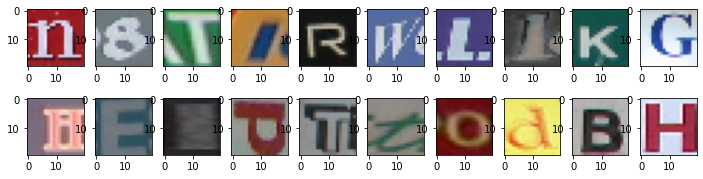

In [3]:
w, h = 2, 2
fig = plt.figure(figsize=(12,3))
columns, rows = 10, 2

train_path = '/kaggle/working/trainResized/'
for i in range(1, 10+1):
    img = imread(train_path+str(i)+'.Bmp')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

test_path = '/kaggle/working/testResized/'
count = 11
for i in range(6284, 6284+10):
    img = imread(test_path+str(i)+'.Bmp')
    fig.add_subplot(rows, columns, count)
    plt.imshow(img)
    count += 1

plt.show()

In [4]:
# ======================= DATA READING START ======================= #

def read_data(typeData, labelsInfo, imageSize, path):
    x = np.zeros((labelsInfo.shape[0], imageSize)) #Intialize x  matrix

    for (index, idImage) in enumerate(labelsInfo["ID"]):
        #Read image file
        nameFile = "{0}/{1}Resized/{2}.Bmp".format(path, typeData, idImage)
        img = imread(nameFile, as_gray=True)
        x[index, :] = np.reshape(img, (1, imageSize))

    return x

imageSize = 400 # 20 x 20 pixels

labelsInfoTrain = pd.read_csv('/kaggle/input/street-view-getting-started-with-julia/trainLabels.csv')
print('train label')
display(labelsInfoTrain.head())
#Read information about test data ( IDs ).
labelsInfoTest = pd.read_csv('/kaggle/input/street-view-getting-started-with-julia/sampleSubmission.csv')
print('submission sample')
display(labelsInfoTest.head())

#Set location of data files , folders
path = '/kaggle/working'
xTrain = read_data("train", labelsInfoTrain, imageSize, path) #Read training matrix
xTest = read_data("test", labelsInfoTest, imageSize, path) #Read test matrix
yTrain = labelsInfoTrain["Class"].to_numpy()

# ======================== DATA READING END ======================== #

train label


,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


submission sample


,ID,Class
0,6284,A
1,6285,A
2,6286,A
3,6287,A
4,6288,A


# Model Experiment

In [5]:
from sklearn.model_selection import train_test_split

training_data, validation_data , training_labels, validation_labels = train_test_split(xTrain, yTrain, test_size = 0.2, random_state = 100)

In [6]:
# -- 1. k-Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [1,3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose =1, cv=3, n_jobs=-1)
#knn = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
knn.fit(training_data,training_labels)
print(knn.best_params_)
print(knn.score(validation_data, validation_labels))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.41686555290373906


In [7]:
prediction = knn.predict(xTest)
labelsInfoTest['Class'] = pd.Series(prediction)
display(labelsInfoTest.head(10))

labelsInfoTest.to_csv('knn_submit.csv', index = False)

,ID,Class
0,6284,H
1,6285,E
2,6286,R
3,6287,d
4,6288,L
5,6289,C
6,6290,g
7,6291,a
8,6292,6
9,6293,H


In [8]:
# -- 2. Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 6, 9, 12],
    'random_state': [0, 1, 2]
}

rf = GridSearchCV(RandomForestClassifier(), grid_params, verbose =1, cv=3, n_jobs=-1)
#RF = RandomForestClassifier(n_estimators=150, max_depth=12, random_state=0)
rf.fit(training_data,training_labels)
print(rf.best_params_)
print(rf.score(validation_data, validation_labels))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 16.3min finished


{'max_depth': None, 'n_estimators': 250, 'random_state': 1}
0.4638027048528242


In [9]:
prediction = rf.predict(xTest)
labelsInfoTest['Class']=pd.Series(prediction)
display(labelsInfoTest.head(10))

labelsInfoTest.to_csv('rf_submit.csv', index = False)

,ID,Class
0,6284,H
1,6285,E
2,6286,A
3,6287,O
4,6288,E
5,6289,E
6,6290,0
7,6291,a
8,6292,S
9,6293,H


In [10]:
# Reshaping dataset for cnn model - idk why

#training_data.shape
training_data_c = training_data.reshape(5026, 20, 20, 1)
#validation_data.shape
validation_data_c = validation_data.reshape(1257, 20, 20, 1)

In [11]:
# -- 3. cnn
from keras.layers import Conv2D,Dense,MaxPool2D,Dropout,Flatten
from keras.models import Sequential
import cv2
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

def create_cnn():
    cmodel=Sequential()
    cmodel.add(Conv2D(32,(3,3),activation='relu',input_shape=(20,20,1), data_format='channels_last'))
    cmodel.add(MaxPool2D((2,2)))
    cmodel.add(Dropout(0.25))
    cmodel.add(Conv2D(64,(3,3),activation='relu'))
    cmodel.add(MaxPool2D((2,2)))
    cmodel.add(Dropout(0.25))
    cmodel.add(Flatten())
    cmodel.add(Dense(128,activation='relu'))
    cmodel.add(Dense(62,activation='softmax'))
    cmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return cmodel


cnn = KerasClassifier(build_fn=create_cnn)

grid_params ={
    #'epochs': [1, 10, 15],
    'batch_size': [1, 10, 100]
}

cnn = GridSearchCV(cnn, grid_params, verbose=1, cv=3, n_jobs=-1)
#cnn = KerasClassifier(build_fn = build_cnn, verbose=1)
cnn.fit(training_data_c,training_labels, epochs=100)
print(cnn.best_params_)
print(cnn.score(validation_data_c, validation_labels))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 26.2min finished


Epoch 1/100
51/51 [==============================] - 1s 20ms/step - loss: 4.0149 - accuracy: 0.0635
Epoch 2/100
51/51 [==============================] - 1s 20ms/step - loss: 3.8719 - accuracy: 0.0686
Epoch 3/100
51/51 [==============================] - 1s 20ms/step - loss: 3.8148 - accuracy: 0.0742
Epoch 4/100
51/51 [==============================] - 1s 21ms/step - loss: 3.7523 - accuracy: 0.0873
Epoch 5/100
51/51 [==============================] - 1s 20ms/step - loss: 3.6146 - accuracy: 0.1357
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 3.3686 - accuracy: 0.2029
Epoch 7/100
51/51 [==============================] - 1s 21ms/step - loss: 3.0915 - accuracy: 0.2563
Epoch 8/100
51/51 [==============================] - 1s 21ms/step - loss: 2.8801 - accuracy: 0.2939
Epoch 9/100
51/51 [==============================] - 1s 21ms/step - loss: 2.6543 - accuracy: 0.3430
Epoch 10/100
51/51 [==============================] - 1s 21ms/step - loss: 2.4682 - accuracy: 0.3701

In [12]:
#xTest.shape
xTest_c = xTest.reshape(6220, 20, 20, 1)

In [13]:
prediction = cnn.predict(xTest_c)
labelsInfoTest['Class'] = pd.Series(prediction)
display(labelsInfoTest.head(10))

labelsInfoTest.to_csv('cnn_submit.csv', index = False)

,ID,Class
0,6284,H
1,6285,E
2,6286,R
3,6287,t
4,6288,T
5,6289,z
6,6290,O
7,6291,J
8,6292,B
9,6293,H
